In [1]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import sys
sys.path.insert(0,'/Users/eman/Documents/code_projects/kernellib/')

import matplotlib.pyplot as plt
%matplotlib inline

/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def sample_data():
    """Gets some sample data."""
    d_dimensions = 1
    n_samples = 20
    noise_std = 0.1
    seed = 123
    rng = np.random.RandomState(seed)


    n_train = 20
    n_test = 5000
    xtrain = np.linspace(-4, 5, n_train).reshape(n_train, 1)
    xtest = np.linspace(-4, 5, n_test).reshape(n_test, 1)

    f = lambda x: np.sin(x) * np.exp(0.2 * x)
    ytrain = f(xtrain) + noise_std * rng.randn(n_train, 1)
    ytest = f(xtest)

    return xtrain, xtest, ytrain, ytest

In [3]:
random_state = 0
rng = np.random.RandomState(random_state)

x_train, x_test, y_train, y_test = sample_data()

# # Training data is 11 points in [0,1] inclusive regularly spaced# Traini 
# x_train = np.linspace(0, 1, 25).reshape(-1, 1)

# # True function is sin(2*pi*x) with Gaussian noise
# y_train = np.sin(x_train * (4 * np.pi)) + rng.randn(x_train.shape[0], 1) * 0.3
# y_train = np.squeeze(y_train)

# x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

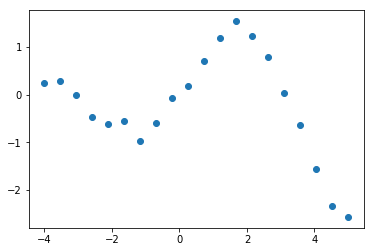

In [4]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train)

plt.show()

### ARD Kernel

In [5]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

In [6]:
ard_kernel = C() * RBF() + WhiteKernel()

## GPR

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [8]:
%%time
gp_model = GaussianProcessRegressor(kernel=ard_kernel, n_restarts_optimizer=10, random_state=0)
gp_model.fit(x_train, y_train)

weights = gp_model.alpha_
signal_variance = gp_model.kernel_.get_params()['k1__k1__constant_value']
length_scale = np.array([gp_model.kernel_.get_params()['k1__k2__length_scale']])
noise_likelihood = gp_model.kernel_.get_params()['k2__noise_level']
K = gp_model.kernel_(x_test, x_train)

y_pred = gp_model.predict(x_test)

CPU times: user 1.65 s, sys: 9.81 s, total: 11.5 s
Wall time: 570 ms


# Full Derivative Map

[Nx dx] = size(x);
[Ns ds] = size(sv);
Kreg = kernel2(x,sv,sigma);
% for p=1:Nx
%     for q=1:Ns
%         for xxx = 1:dx
%             map0(xxx,p,q) = alpha(q) * (x(p,xxx)-sv(q,xxx)) * Kreg(p,q);
%         end
%     end
% end

map2 = zeros(dx,Nx,Ns);
for p=1:Nx
        map2(:,p,:) = (repmat(alpha,1,size(sv,2)) .* (repmat(x(p,:),size(sv,1),1)-sv) .* repmat(Kreg(p,:)',1,size(sv,2)))';
        %p
end

In [9]:
# import sys
# sys.path.insert(0, '/home/emmanuel/Drives/erc/code/kernellib')

# from kernellib.derivatives import ard_derivative

In [10]:
# print(np.ndim(x_test))

## Pure Python

In [11]:
def ard_full_py(x_train, x_function, K, weights, length_scale):
    
    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    constant = -np.power(length_scale, -2)
    for itest in range(n_test):
        for itrain in range(n_train):
            for idim in range(d_dims):
                derivative[itest, itrain, idim] = \
                    constant[idim] * weights[itrain] \
                    * (x_function[itest, idim] - x_train[itrain, idim]) \
                    * K[itest, itrain]
        
    return derivative

In [12]:
d1_map_py = ard_full_py(x_train, x_test, K, weights, length_scale)
d1_der_py = d1_map_py.sum(axis=1)
print(d1_der_py.shape)

(5000, 1)


In [13]:
pyed = %timeit -o ard_full_py(x_train, x_test, K, weights, length_scale)

519 ms ± 2.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


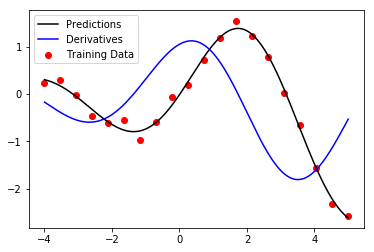

In [14]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, color='r', label='Training Data')
ax.plot(x_test, y_pred, color='k', label='Predictions')
ax.plot(x_test, d1_der_py, color='b', label='Derivatives')

ax.legend()
plt.show()

#### Check Gradient

In [15]:
from scipy.optimize import check_grad, approx_fprime

In [16]:
def my_grad(X):
    full_d = rbf_full_py(x_train, X.reshape(-1,1), K, weights, gamma)
    d1 = full_d.sum(axis=1).flatten()
    return d1

def my_pred(X):
    pred = krr_model.predict(X.reshape(-1, 1)).flatten()
    return pred.flatten()

d1_numerical = list()
for i in x_test:
    d1_numerical.append(approx_fprime(i, my_pred, [eps]))

d1_numerical = np.array(d1_numerical)
eps = np.sqrt(np.finfo(float).eps)

x = np.linspace(0, 1, 100)

errs = list()
for i in x_test:
    
    errs.append(check_grad(my_pred, my_grad, i))

    
fig, ax = plt.subplots()

ax.plot(x_test, d1_numerical)
ax.plot(x_test, d1_der_py)
plt.show()

fig, ax = plt.subplots()

ax.plot(x_test, np.array(errs))

plt.show()

NameError: name 'eps' is not defined

## Numpy

In [17]:
def ard_full_numpy(x_train, x_function, K, weights, gamma):

    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    constant = np.diag(-np.power(length_scale, -2))
    
    weights = np.tile(weights, (1, d_dims))
    
    for itest in range(n_test):
        X = (np.tile(x_function[itest, :], (n_train, 1)) - x_train).dot(constant)
        
        term3 = np.tile(K[itest, :].T, (1, d_dims)).T
        derivative[itest, :, :] = X * weights * term3

    return derivative

In [18]:
d1_map_np = ard_full_numpy(x_train, x_test, K,  weights, length_scale)

In [19]:
npyed = %timeit -o ard_full_numpy(x_train, x_test, K, weights, length_scale)

62.2 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
print('Numpy Speed up: ', pyed.best / npyed.best)

Numpy Speed up:  8.30139604394509


In [21]:
np.testing.assert_array_almost_equal(d1_map_py, d1_map_np, decimal=12)

## Numba

In [22]:
import numba
from numba import jit, njit, prange

In [23]:
@njit(fastmath=True)
def ard_full_numba(x_train, x_function, K, weights, length_scale):
    
    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    constant = -np.power(length_scale, -2)
    for idim in range(d_dims):
        for itrain in range(n_train):
            for itest in prange(n_test):
                derivative[itest, itrain, idim] = \
                    constant[idim] * weights[itrain] \
                    * (x_function[itest, idim] - x_train[itrain, idim]) \
                    * K[itest, itrain]
        
    return derivative

In [24]:
d1_map_numba = ard_full_numba(x_train, x_test, K, weights.flatten(), length_scale)

In [25]:
jitted = %timeit -o ard_full_numba(x_train, x_test, K, weights.flatten(), length_scale)

625 µs ± 136 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
print('Jitted Speed up (Numpy): ', npyed.best / jitted.best)
print('Numba Speed up (Python): ', pyed.best / jitted.best)

Jitted Speed up (Numpy):  99.07153437903861
Numba Speed up (Python):  822.4320435617212


In [27]:
np.testing.assert_array_almost_equal(d1_map_py, d1_map_numba, decimal=12)

# Derivative

## Pure Python

In [72]:
def ard_derivative_py(x_train, x_function, K, weights, length_scale):
    
    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    constant = -np.power(length_scale, -2)
    for itest in range(n_test):
        for itrain in range(n_train):
            for idim in range(d_dims):
                derivative[itest, itrain, idim] = \
                    constant[idim] * weights[itrain] \
                    * (x_function[itest, idim] - x_train[itrain, idim]) \
                    * K[itest, itrain]
    derivative = derivative.sum(axis=1)
    return derivative

In [73]:
d1_der_py = ard_derivative_py(x_train, x_test, K, weights, length_scale)

In [74]:
pyedd = %timeit -o ard_derivative_py(x_train, x_test, K, weights, length_scale)

512 ms ± 2.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Plot

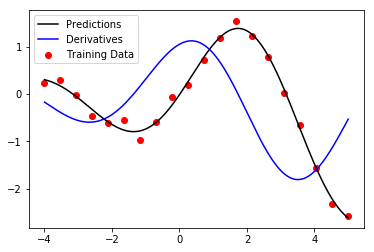

In [75]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, color='r', label='Training Data')
ax.plot(x_test, y_pred, color='k', label='Predictions')
ax.plot(x_test, d1_der_py, color='b', label='Derivatives')

ax.legend()
plt.show()

## Numpy

#### Version I

In [76]:
def ard_derivative_numpy1(x_train, x_function, K, weights, length_scale, sign):
    if np.ndim(x_function) == 1:
        x_function = x_function[np.newaxis, :]
    if np.ndim(weights) == 1:
        weights = weights[:, np.newaxis]
    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    constant = -2*gamma
    
    for itest in range(n_test):
        term1 = (np.tile(x_function[itest, :], (n_train, 1)) - x_train)
        term2 = np.tile(weights, (1, d_dims))
        term3 = np.tile(K[itest, :].T, (1, d_dims)).T
        derivative[itest, :, :] = term1 * term2 * term3\

    derivative = np.sum(derivative, axis=1)
    return derivative

#### Version II

In [77]:
def ard_derivative_np(x_train, x_function, K, weights, length_scale):
    
#     # check the sizes of x_train and x_test
#     err_msg = "xtrain and xtest d dimensions are not equivalent."
#     np.testing.assert_equal(x_function.shape[1], x_train.shape[1], err_msg=err_msg)
    
#     # check the n_samples for x_train and weights are equal
#     err_msg = "Number of training samples for xtrain and weights are not equal."
#     np.testing.assert_equal(x_train.shape[0], weights.shape[0], err_msg=err_msg)

    
    
    n_test, n_dims = x_function.shape

    derivative = np.zeros(shape=x_function.shape)
    length_scale = np.diag(- np.power(length_scale, -2))
    for itest in range(n_test):
        derivative[itest, :] = np.dot(length_scale.dot((x_function[itest, :] - x_train).T),  
                                      (K[itest, :].reshape(-1, 1) * weights))

        
    return derivative

In [78]:
d1_der_np = ard_derivative_np(x_train, x_test, K, weights, length_scale)

In [79]:
np.testing.assert_array_almost_equal(d1_der_py, d1_der_np, decimal=12)

In [80]:
npyedd = %timeit -o ard_derivative_np(x_train, x_train, K, weights, length_scale)

144 µs ± 27.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [81]:
print('Numpy Speed up: ', pyedd.best / npyedd.best)

Numpy Speed up:  4092.709831749194


In [82]:
np.testing.assert_array_almost_equal(d1_der_py, d1_der_np, decimal=12)

#### Version II

In [287]:
# def rbf_derivative_np2(x_train, x_function, K, weights, gamma):
    
# #     # check the sizes of x_train and x_test
# #     err_msg = "xtrain and xtest d dimensions are not equivalent."
# #     np.testing.assert_equal(x_function.shape[1], x_train.shape[1], err_msg=err_msg)
    
# #     # check the n_samples for x_train and weights are equal
# #     err_msg = "Number of training samples for xtrain and weights are not equal."
# #     np.testing.assert_equal(x_train.shape[0], weights.shape[0], err_msg=err_msg)

    
    
#     n_test, n_dims = x_function.shape

#     derivative = np.zeros(shape=x_function.shape)

#     constant = - 2 * gamma
# #     print(x_train.T.shape)
# #     print(np.diag(weights.flatten()).shape, K.T.shape)
# #     print(weights.T.shape, K.T.shape)
#     derivative = x_train.T.dot(np.diag(weights.flatten()).dot(K.T) - np.diag(weights.T.dot(K.T))).T

#     derivative *= constant
        
#     return derivative

In [288]:
# d1_der_np2 = rbf_derivative_np2(x_train, x_train, K, weights, gamma)

In [289]:
# npyedd2 = %timeit -o rbf_derivative_np2(x_train, x_train, K, weights, gamma)

185 µs ± 6.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [290]:
# print('Numpy2 Speed up: ', pyedd.best / npyedd2.best)

Numpy2 Speed up:  361.86849062941303


In [39]:
# np.testing.assert_almost_equal(d1_der_py, d1_der_np2, decimal=3)

## Numba

In [ ]:
K[itest, :].reshape(-1, 1)

In [139]:
@njit('double[:,:](double[:,:], double[:,:], double[:,:],double[:,:], double[:])', fastmath=True, nogil=False)
def ard_derivative_numba(x_train, x_function, K, weights, length_scale):
    
#     # check the sizes of x_train and x_test
#     err_msg = "xtrain and xtest d dimensions are not equivalent."
#     np.testing.assert_equal(x_function.shape[1], x_train.shape[1], err_msg=err_msg)
    
#     # check the n_samples for x_train and weights are equal
#     err_msg = "Number of training samples for xtrain and weights are not equal."
#     np.testing.assert_equal(x_train.shape[0], weights.shape[0], err_msg=err_msg)

    
    
    n_test, n_dims = x_function.shape

    derivative = np.zeros(shape=x_function.shape)
    
    length_scale = np.diag(- np.power(length_scale, -2))

    for itest in range(n_test):
        derivative[itest, :] = np.dot(np.dot(length_scale, (x_function[itest, :] - x_train).T),  
                                      (np.expand_dims(K[itest, :], axis=1) * weights))
        
    return derivative

In [140]:
# ard_derivative_numba.inspect_types()

In [141]:
print(x_train.shape, x_test.shape, K.shape, weights.shape, length_scale.shape)
d1_der_nmb = ard_derivative_numba(x_train, x_test, K, weights, length_scale)
print(d1_der_nmb.shape)
np.testing.assert_array_almost_equal(d1_der_py, d1_der_nmb, decimal=10)

(20, 1) (5000, 1) (5000, 20) (20, 1) (1,)
(5000, 1)


In [142]:
jittedd = %timeit -o -r 10 ard_derivative_numba(x_train, x_train, K, weights, length_scale)

15.6 µs ± 16.7 ns per loop (mean ± std. dev. of 10 runs, 100000 loops each)


In [113]:
print('Numpy Speed up: ', npyedd.best / jittedd.best)
print('Python Speed up: ', pyedd.best / jittedd.best)

Numpy Speed up:  7.91833554415751
Python Speed up:  32407.449732662546


In [114]:
np.testing.assert_array_almost_equal(d1_der_nmb, d1_der_np, decimal=12)

# 2nd Map Derivative

$$\frac{\partial^2f}{x^2}=2\gamma \left[2 \gamma( x^j - y^j )^2 - 1  \right] K(x,y)$$

## Pure Python

In [328]:
def ard_full2_py(x_train, x_function, K, weights, gamma):
    
    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    constant = np.power(1 / length_scale, 2)
    
    for idim in range(d_dims):
        for itrain in range(n_train):
            for itest in range(n_test):
                derivative[itest, itrain, idim] = \
                    (constant[idim] + (constant[idim] * (x_function[itest, idim] - x_train[itrain, idim]))**2) \
                    * K[itest, itrain] * weights[itrain, 0]
    
    
    return derivative

In [329]:
d2_map_py = ard_full2_py(x_train, x_test, K, weights, length_scale)
d2_der_py = d2_map_py.sum(axis=1)
print(d2_der_py.shape)

(5000, 1)


In [330]:
# pyed2 = %timeit -o ard_full2_py(x_train, x_test, K, weights, length_scale)

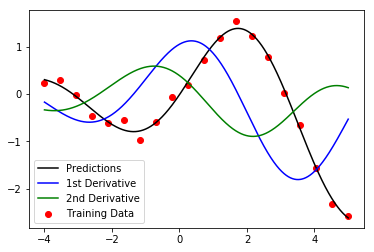

In [331]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, color='r', label='Training Data')
ax.plot(x_test, y_pred, color='k', label='Predictions')
ax.plot(x_test, d1_der_py, color='b', label='1st Derivative')
ax.plot(x_test, d2_der_py, color='g', label='2nd Derivative')


ax.legend()
plt.show()

## Numpy

In [415]:
def rbf_full2_numpy(x_train, x_function, K, weights, gamma):

    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    constant = 2*gamma
    
    term2 = np.tile(weights, (1, d_dims))
    
    for itest in range(n_test):
        
        term1 = constant * (np.tile(x_function[itest, :], (n_train, 1)) - x_train)**2 - 1
#         print(term1.shape)
        
#         print(term2.shape)
        term3 = np.tile(K[itest, :].T, (1, d_dims)).T
#         print(term3.shape)
        derivative[itest, :, :] = term1 * term2 * term3
#         break

    derivative *= constant
    return derivative

In [416]:
d2_map_np = rbf_full2_numpy(x_train, x_test, K,  weights, gamma)

In [417]:
npyed2 = %timeit -o rbf_full2_numpy(x_train, x_test, K, weights, gamma)

75.2 ms ± 3.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [418]:
print('Numpy Speed up: ', pyed2.best / npyed2.best)

Numpy Speed up:  2.0140130652693147


In [419]:
np.testing.assert_array_almost_equal(d2_map_py, d2_map_np)

## Numba

In [242]:
@njit(fastmath=True)
def rbf_full2_numba(x_train, x_function, K, weights, length_scale):
    
    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    constant = -np.power(length_scale, -2)
    for idim in range(d_dims):
        for itrain in range(n_train):
            for itest in prange(n_test):
                derivative[itest, itrain, idim] = \
                     constantweights[itrain]\
                    * (constant * (x_function[itest, idim] - x_train[itrain, idim])**2 - 1) \
                    * K[itest, itrain]
    
    derivative *= constant
    
    return derivative

In [243]:
d2_map_numba = rbf_full2_numba(x_train, x_test, K,  weights.flatten(), gamma)

TypingError: Failed at nopython (nopython frontend)
Untyped global name 'constantweights': cannot determine Numba type of <class 'object'>

File "<ipython-input-242-ba5680bbf283>", line 13:
def rbf_full2_numba(x_train, x_function, K, weights, length_scale):
    <source elided>
            for itest in prange(n_test):
                derivative[itest, itrain, idim] =                      constantweights[itrain]                    * (constant * (x_function[itest, idim] - x_train[itrain, idim])**2 - 1)                     * K[itest, itrain]
                ^

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [422]:
jitted2 = %timeit -o rbf_full2_numba(x_train, x_test, K, weights.flatten(), gamma)

790 µs ± 31.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [423]:
print('Python Speed up: ', pyed2.best / jitted2.best)
print('Numpy Speed up: ', npyed2.best / jitted2.best)

Python Speed up:  192.0840963113116
Numpy Speed up:  95.37380845422969
